<a href="https://colab.research.google.com/github/LH-1169213/Equipo3/blob/main/SVM_Equipo03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Inteligencia Artificial y Aprendizaje Automático**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Adtividad de la Semana 8**
###**Máquina de Vector Soporte - Support Vector Machine(SVM)**


**Nombres y matrículas de los integrantes del equipo:**

*   Samara García González A01273001
*   Laura Elena Hernández Mata A01169213
*   Evelyn Aylin Rendon Medina A01748750
*   Emmanuel González Calitl A01320739
*   Carlos Enrique Diaz Ayala A01793816

En cada sección deberás incluir todas las líneas de código necesarias para responder a cada uno de los ejercicios.

In [1]:
# Incluye aquí todos módulos, librerías y paquetes que requieras.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import  cross_validate
from sklearn.metrics import make_scorer

from sklearn.model_selection import learning_curve, validation_curve

import sklearn
from sklearn import svm
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, roc_curve, RocCurveDisplay

from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.metrics import recall_score #SÓLO PARA VALIDACIÓN
from sklearn.metrics import f1_score #SÓLO PARA VALIDACIÓN
from sklearn.metrics import make_scorer #SÓLO PARA VALIDACIÓN
from imblearn.metrics import geometric_mean_score #SÓLO PARA VALIDACIÓN
from sklearn.metrics import confusion_matrix #SÓLO PARA VALIDACIÓN

from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification



In [2]:
#Funciones de errores
def RMSEFunction(yReal, yEstimada):
  return np.sqrt(np.mean(np.square(yReal-yEstimada)))

def MAEFunction(yReal, yEstimada):
  return np.mean(np.abs(yReal-yEstimada)) 

def MAPEFunction(yReal, yEstimada):
  return np.mean(np.abs((yReal-yEstimada)/yReal))*100

In [3]:
#Funciones de métricas

#FUNCIÓN ACCURACY
def accuracyFunction(Yreal, Yestimada):
  vn, fp, fn, vp = confusion_matrix(Yreal, Yestimada).ravel()
  accuracy = (vp+vn)/(vp+vn+fp+fn+np.finfo(np.float32).eps)
  return accuracy
#FUNCION PRECISIÓN 
def precisionFunction(Yreal, Yestimada):
  vn, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
  precision = vp / (vp+fp+np.finfo(np.float32).eps)
  return precision
#FUNCIÓN RECALL
def recallFunction(Yreal, Yestimada):
  vn, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
  recall = vp / (vp+fn+np.finfo(np.float32).eps)
  return recall
#FUNCIÓN F1 SCORE
def f1Function(Yreal, Yestimada):
  vn, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
  f1score = 2*vp / (2*vp+fp+fn+np.finfo(np.float32).eps)
  return f1score
#FUNCIÓN ESPECIFICIDAD
def especificidadFunction(Yreal, Yestimada):
  vn, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
  especificidad = vn / (vn+fp+np.finfo(np.float32).eps)
  return especificidad
#FUNCIÓN GMEAN
def gmeanFunction(Yreal, Yestimada):
 vp, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
 gmean = np.sqrt(recallFunction(Yreal, Yestimada) * especificidadFunction(Yreal, Yestimada))
 return gmean

#**Preparación del data frame:**

In [4]:
#Obtener el data set:

path = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"
titles =  ['A1', 'A2','A3', 'A4','A5', 'A6','A7', 'A8','A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15']

datos_originales = pd.read_csv(path, sep = " ", names = titles)
datos_originales.head()


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [5]:
df = datos_originales

In [6]:
df.dtypes

A1       int64
A2     float64
A3     float64
A4       int64
A5       int64
A6       int64
A7     float64
A8       int64
A9       int64
A10      int64
A11      int64
A12      int64
A13      int64
A14      int64
A15      int64
dtype: object

Sin columnas tipo objeto.

In [7]:
#Remplazar signos de interrogación a Nan's:
df=df.replace('?',np.NaN)

In [8]:
#OBTENEMOS LA INFORMACIÓN DE NUESTRO DF
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    int64  
 1   A2      690 non-null    float64
 2   A3      690 non-null    float64
 3   A4      690 non-null    int64  
 4   A5      690 non-null    int64  
 5   A6      690 non-null    int64  
 6   A7      690 non-null    float64
 7   A8      690 non-null    int64  
 8   A9      690 non-null    int64  
 9   A10     690 non-null    int64  
 10  A11     690 non-null    int64  
 11  A12     690 non-null    int64  
 12  A13     690 non-null    int64  
 13  A14     690 non-null    int64  
 14  A15     690 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 81.0 KB


In [9]:
df.isna().any()

A1     False
A2     False
A3     False
A4     False
A5     False
A6     False
A7     False
A8     False
A9     False
A10    False
A11    False
A12    False
A13    False
A14    False
A15    False
dtype: bool

Sin valores Nan's

In [10]:
# DEFINICIÓN DE LAS VARIABLES

X = df.iloc[:,0:14] # VARIABLES DE ENTRADA

y = df["A15"] # VARIABLE DE SALIDA

#**Ejercicio-1.** 

Realiza una partición de los datos con 15% en el conjunto de prueba y el resto para entrenamiento y
validación. Usa un random_state=0. 


In [11]:
# Partición de datos:
#Datos totales 690, 15% -> 104 para prueba.

Xtrain, Xtest, Ytrain, Ytest =  train_test_split(X,y, test_size = 0.15, random_state = 0) 

# REVISAMOS QUE LA PARTICIÓN HAYA SIDO CORRECTA
print("Tamaño de las variables de entrada y salida sin partición (X & y)")
print(X.shape, y.shape)

print("Tamaño de los valores de entrenamiento (Xtrain & Ytrain)")
print(Xtrain.shape, Ytrain.shape)

print("Tamaño de los valores de prueba (Xtest & Ytest)")
print(Xtest.shape, Ytest.shape)

Tamaño de las variables de entrada y salida sin partición (X & y)
(690, 14) (690,)
Tamaño de los valores de entrenamiento (Xtrain & Ytrain)
(586, 14) (586,)
Tamaño de los valores de prueba (Xtest & Ytest)
(104, 14) (104,)


#**Ejercicio-2.**

 Hacer una análisis de los datos y llevar a cabo las transformaciones que consideres adecuadas.
Utiliza un Pipeline para evitar el filtrado de información. 

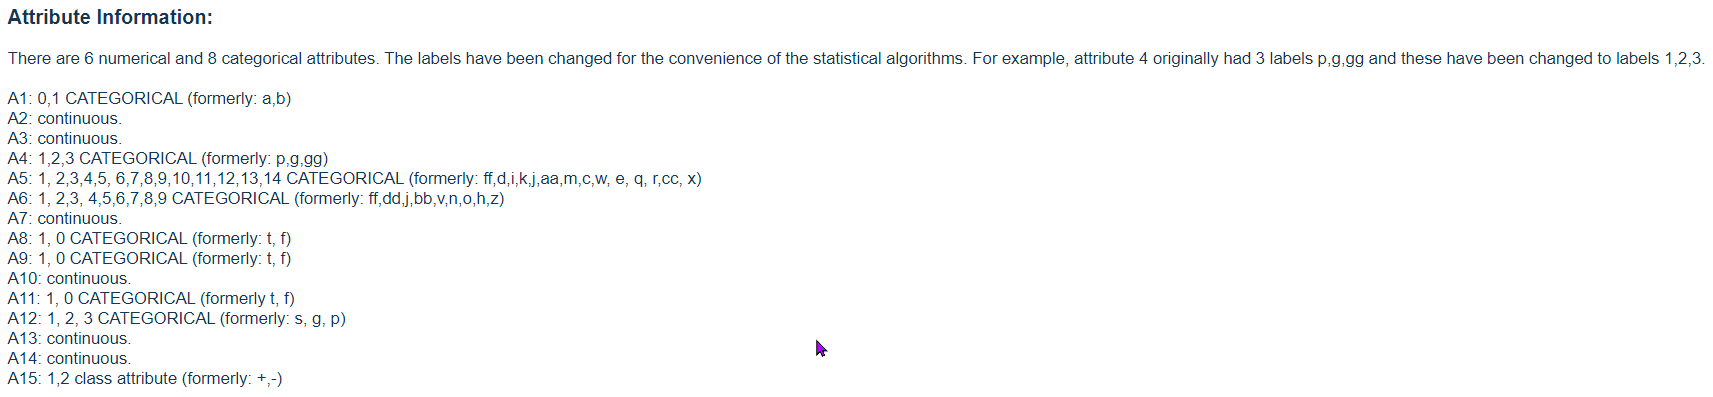

In [12]:
df.describe()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.678261,31.568203,4.758725,1.766667,7.372464,4.692754,2.223406,0.523188,0.427536,2.40000,0.457971,1.928986,184.014493,1018.385507,0.444928
std,0.467482,11.853273,4.978163,0.430063,3.683265,1.992316,3.346513,0.499824,0.495080,4.86294,0.498592,0.298813,172.159274,5210.102598,0.497318
min,0.000000,13.750000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,22.670000,1.000000,2.000000,4.000000,4.000000,0.165000,0.000000,0.000000,0.00000,0.000000,2.000000,80.000000,1.000000,0.000000
50%,1.000000,28.625000,2.750000,2.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.00000,0.000000,2.000000,160.000000,6.000000,0.000000
75%,1.000000,37.707500,7.207500,2.000000,10.000000,5.000000,2.625000,1.000000,1.000000,3.00000,1.000000,2.000000,272.000000,396.500000,1.000000
max,1.000000,80.250000,28.000000,3.000000,14.000000,9.000000,28.500000,1.000000,1.000000,67.00000,1.000000,3.000000,2000.000000,100001.000000,1.000000


Los valores de variables catégoricas están dentro del rango, no es necesario corregir rangos.

In [13]:
# DIVISIÓN DE VARIABLES DE ENTRADA EN CATEGÓRICA, ORDINAL, NUMÉRICA Y BINARIA

categorical_vars = ['A4', 'A5', 'A6', 'A12'] #Variables categóricas
ordinal_vars = [] #Variables cuantitativas discretizadas
quantitative_vars = ['A2', 'A3', 'A7', 'A10', 'A13', 'A14'] #Variables numéricas
in_binary_vars = ['A1', 'A8', 'A9', 'A11'] #Variables binarias de entrada
out_binary_vars = ['A15'] #Variables binarias de salida

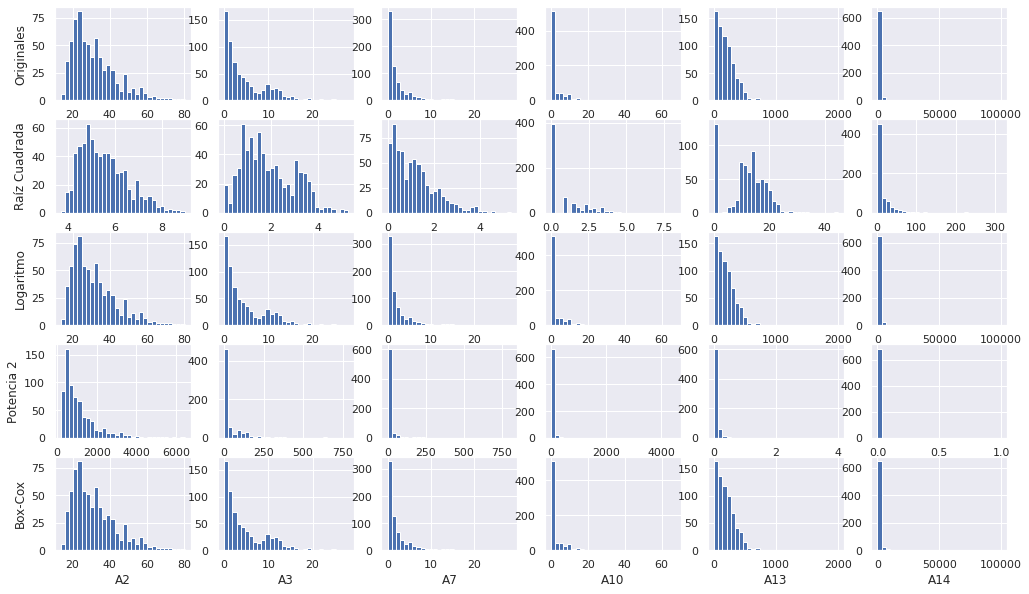

In [93]:
# CONOCIENDO EL COMPORTAMIENTO DE NUESTRAS VARIABLES

variables_a_transformar = quantitative_vars


sns.set(rc={'figure.figsize':(20,10)})
fig, axes = plt.subplots(5, 5)   

  
for k in range(0,6):       
 
    # Datos originales 
    plt.subplot(5,7,k+1) 

    Transf0 = df[variables_a_transformar[k]]          
    plt.hist(Transf0,bins=30)                               

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Originales')
    
    # Datos transformados con raíz cuadrada 
    plt.subplot(5,7,k+8)    

    Transf1 = np.sqrt(Transf0)          
    plt.hist(Transf1, bins=30)               

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Raíz Cuadrada')
      
    # Datos transformados con logaritmo natural 
    plt.subplot(5,7,k+15)     

    Transf2 =  Transf0  #np.log(Transf0) *************************************** <------------------------------------------ log(0) -infinite         
    plt.hist(Transf2,bins=30)          

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Logaritmo')
    
    # Datos transformados con la potencia de 2 
    plt.subplot(5,7,k+22)

    Transf3 = np.power(Transf0,2)          
    plt.hist(Transf3,bins=30)              

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Potencia 2')
    

    # # Datos transformados con Box-Cox 
    plt.subplot(5,7,k+29)

    Transf4 = Transf0  #power_transform(Transf0.to_frame(),method="box-cox") #np.log(Transf0) ******** <------------------------------------------ Método box cox no acepta 0           
    plt.hist(Transf4,bins=30)                                               

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Box-Cox')


plt.show()

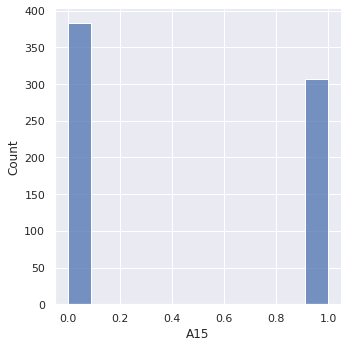

In [86]:
#
sns.displot(df['A15'])

In [16]:
num_credits = df['A15'].value_counts()
num_credits

0    383
1    307
Name: A15, dtype: int64

Clases ligeramente desbalanceadas, se niegan más créditos de los que se entregan.

In [17]:
# PIPELINE, ESCALACIÓN DE DATOS CUANTITATIVOS CON EL MÉTODO DE MinMaxScaler,
quantitative_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler',MinMaxScaler(feature_range=(1,2)))])
col_quantitative = quantitative_vars

# TRANSFORMACIÓN ONE HOT ENCODER PARA VARIABLES CATEGÓRICAS Y BINARIAS.
categorical_pipeline = Pipeline(steps = [("imputer", SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown="ignore"))])
col_categorical = categorical_vars

binary_pipeline = Pipeline(steps = [("imputer", SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown="ignore"))])
col_binary_in = in_binary_vars

#No se usan variables ordinals, se quita del cols transformer
#ordinal_pipeline = Pipeline(steps = [("imputer", SimpleImputer(strategy='most_frequent'))]) 
#col_ordinal = ordinal_vars

cols_Transformer = ColumnTransformer(transformers = [('quantitative', quantitative_pipeline, col_quantitative),
                                                        ('categorical', categorical_pipeline, col_categorical),
                                                        ('binary_in', binary_pipeline, col_binary_in), 
                                                        ], remainder='passthrough')


In [18]:
#REVISIÓN DE CONFIGURACIÓN
X_train_fit = cols_Transformer.fit(Xtrain)
print(X_train_fit)


ColumnTransformer(remainder='passthrough',
                  transformers=[('quantitative',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler',
                                                  MinMaxScaler(feature_range=(1,
                                                                              2)))]),
                                 ['A2', 'A3', 'A7', 'A10', 'A13', 'A14']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['A4', 'A5', 'A6', 'A12']),
                                ('binary_in',
                                 Pipeline(steps=[('imputer',
     

#**Ejercicio-3.**

Utiliza la función Dummy para modelos de clasificación con la estrategia “stratified” con el conjunto
que tienes de datos de entrenamiento y validación. Obtener los valores de partida (baseline) de las 
siguientes métricas: accuracy, f1-score, precision y recall. ¿Por qué consideras que es adecuado usar
la estrategia “stratified” en este caso? 

 

In [19]:
# HACEMOS LA PARTICIÓN DE LOS DATOS TOMANDO COMO BASE LOS DATOS DE ENTRENAMIENTO Y VALIDACIÓN (Xtrain, Ytrain)
# QUE ESTABLECIMOS PREVIAMENTE

Xtrain2, Xval, Ytrain2, Yval = train_test_split(Xtrain, Ytrain, train_size = 410, test_size = 176, random_state = 0)

# REVISAMOS QUE LA PARTICIÓN HAYA SIDO CORRECTA
print("Tamaño de las variables de entrada y salida sin partición (X & y)")
print(X.shape, y.shape)

print("\n------Partición del Ejercicio 1:------")

print("Tamaño de los valores de entrenamiento (Xtrain & Ytrain)")
print(Xtrain.shape, Ytrain.shape)

print("Tamaño de los valores de prueba (Xtest & Ytest)")
print(Xtest.shape, Ytest.shape)


print("\n------Partición actual:------")

print("Tamaño de los valores de entrenamiento actuales (Xtrain2 & Ytrain2)")
print(Xtrain2.shape, Ytrain2.shape)

print("Tamaño de los valores de validación (Xval & Yval)")
print(Xval.shape, Yval.shape)

Tamaño de las variables de entrada y salida sin partición (X & y)
(690, 14) (690,)

------Partición del Ejercicio 1:------
Tamaño de los valores de entrenamiento (Xtrain & Ytrain)
(586, 14) (586,)
Tamaño de los valores de prueba (Xtest & Ytest)
(104, 14) (104,)

------Partición actual:------
Tamaño de los valores de entrenamiento actuales (Xtrain2 & Ytrain2)
(410, 14) (410,)
Tamaño de los valores de validación (Xval & Yval)
(176, 14) (176,)


In [20]:
dummy_clf = DummyClassifier(strategy = "stratified") #Estrategia solicitada en las instrucciones del ejercicio

dummy_clf.fit(Xtrain2, Ytrain2)

Ytrain2_hat = dummy_clf.predict(Xtrain2)
Ytest2_hat = dummy_clf.predict(Xval)

print("\n------Resultados de métricas:------")
print("\nAccuracy entrenamiento:", accuracyFunction(Ytrain2.values, Ytrain2_hat))
print("Accuracy validación:", accuracyFunction(Yval.values, Ytest2_hat))
#f1-score, precision y recall
print("\nf1-score entrenamiento:", f1Function(Ytrain2.values, Ytrain2_hat))
print("f1-score validación:", f1Function(Yval.values, Ytest2_hat))
print("\nPrecision entrenamiento:", precisionFunction(Ytrain2.values, Ytrain2_hat))
print("Precision validación:", precisionFunction(Yval.values, Ytest2_hat))
print("\nRecall entrenamiento:", recallFunction(Ytrain2.values, Ytrain2_hat))
print("Recall validación:", recallFunction(Yval.values, Ytest2_hat))


------Resultados de métricas:------

Accuracy entrenamiento: 0.507317073023227
Accuracy validación: 0.5397727269071254

f1-score entrenamiento: 0.4388888887435566
f1-score validación: 0.45637583856104535

Precision entrenamiento: 0.443820224421868
Precision validación: 0.4857142848871192

Recall entrenamiento: 0.43406593378162256
Recall validación: 0.4303797461860093


Las métricas de los anteriores modelos es obviamente mucho mejor que la del modelo base (Baseline) de 0.55.

**¿Por qué consideras que es adecuado usar la estrategia “stratified” en este caso?**

***Respuesta:** El clasificador Dummy es la base para nuestros siguientes modelos, es decir no podemos tener scores menores al dummy ya que este modelo hace predicciones de manera muy sencilla. Asimimso, es válido usar la estrategia "stratified" dado que respeta la distribución de las clases de nuestro target y no hace predicciones de manera aleatoria.*

#**Ejercicio-4.**

Usando el modelo de máquina de vector soporte (SVM) encuentra sus mejores hiperparámetros con una búsqueda de malla y validación cruzada, desplegando los errores indicados en el ejercicio anterior. 

In [21]:
# OBTENEMOS LOS PARÁMETROS

#from sklearn import svm
svm_clasification = svm.SVC()
svm_clasification.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

SVM_params = [{'C': [0.1, 1, 10, 100, 1000],
               'decision_function_shape': ['ovo', 'ovr'],
               'degree': [1,2,3,4],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],}]

In [32]:
# OBTENEMOS EL MODELO
SVM = svm.SVC()
SVM_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", SVM)])
SVM_kfold= RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)


# ELEGIMOS PARÁMETROS
SVM_params = [{'model__C': [0.1, 1, 10, 100, 1000],
               'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'model__kernel': ['rbf', 'sigmoid']}]


# MÉTRICAS A OBTENER
mis_metricas={
    'accuracy': make_scorer(accuracyFunction),
    'f1score': make_scorer(f1Function),
    'precision': make_scorer(precisionFunction),
    'recall': make_scorer(recallFunction),
    "gmean": make_scorer(gmeanFunction)}


# BÚSQUEDA POR GRID
SVM_bestParams = {}

for key, metrica in mis_metricas.items():
  SVM_grid = GridSearchCV(n_jobs = -1,
                        estimator =  SVM_pipe, 
                        param_grid = SVM_params,
                        scoring = metrica,
                        cv = SVM_kfold)
  
  SVM_grid.fit(Xtrain, Ytrain)
  SVM_bestScore = SVM_grid.best_score_
  SVM_bestParam = SVM_grid.best_params_
  SVM_bestParams[metrica] = SVM_grid.best_params_
  print('\nMétrica: {0} '.format(key))
  print('El mejor puntaje (score) es:',SVM_bestScore)
  print('Los mejores parámetros son:',SVM_bestParam )


Métrica: accuracy 
El mejor puntaje (score) es: 0.8560915535258554
Los mejores parámetros son: {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}

Métrica: f1score 
El mejor puntaje (score) es: 0.8481908929581273
Los mejores parámetros son: {'model__C': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}

Métrica: precision 
El mejor puntaje (score) es: 0.9697394970255613
Los mejores parámetros son: {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'rbf'}

Métrica: recall 
El mejor puntaje (score) es: 0.9348572789486556
Los mejores parámetros son: {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'sigmoid'}

Métrica: gmean 
El mejor puntaje (score) es: 0.8556264527202216
Los mejores parámetros son: {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


#**Ejercicio-5.**

Obtener además los diagramas de caja y bigote del mejor modelo con todas las métricas calculadas. 

In [34]:
# MEJORES PARÁMETROS PARA CADA MÉTRICA
diccionario = dict()
j=0

for i in SVM_bestParams.keys():
  SVC_final = svm.SVC(C=SVM_bestParams[i]['model__C'], gamma=SVM_bestParams[i]['model__gamma'], kernel=SVM_bestParams[i]['model__kernel'])
  SVM_pipeF = Pipeline(steps=[("PreparaInfo", cols_Transformer),("modelo", SVC_final)])
  SVM_kfoldF= RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  SVM_score = cross_validate(SVM_pipeF, Xtrain, Ytrain, scoring=i, cv=SVM_kfoldF, return_train_score=True)
  diccionario[i] = SVM_score


In [35]:
# SE OBTIENEN LOS NOMBRES DE LAS MÉTRICAS
listaNames = list()

for i in SVM_bestParams.keys():
  listaNames.append(i)

<function matplotlib.pyplot.show(*args, **kw)>

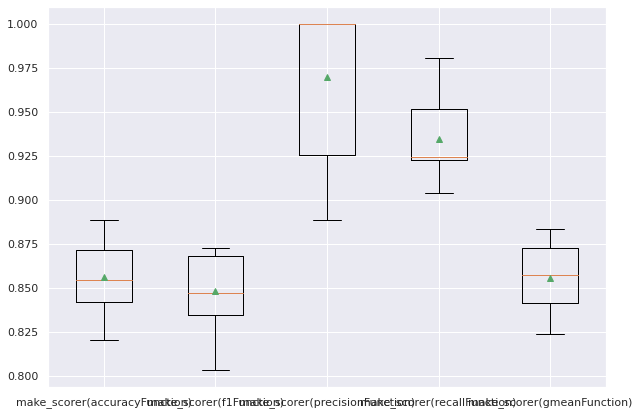

In [36]:
# BOXPLOT PARA CADA MÉTRICA
dataList = list()
sns.set(rc={'figure.figsize':(10,7)})
for i in diccionario.keys():
  data = diccionario[i]['test_score']
  dataList.append(data)

plt.boxplot(dataList, labels = listaNames, showmeans=True)
plt.show

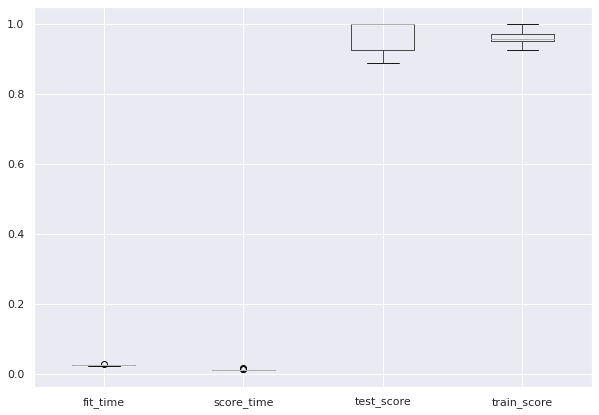

In [38]:
# MEJORES PARÁMETROS
SVM_final = svm.SVC(C=1, gamma=0.001, kernel='rbf')
SVM_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", SVM_final)])
SVM_score = cross_validate(SVM_pipe, Xtrain, Ytrain, scoring=make_scorer(precisionFunction), cv=SVM_kfold, return_train_score=True)

# DIAGRAMA DE CAJAS Y BIGOTES
sns.set(rc={'figure.figsize':(10,7)})
SVM_df = pd.DataFrame(SVM_score)
SVM_df.boxplot()

**Incluye tus conclusiones**

*Es posible observar en el diagrama de cajas y bigotes que la distribución obtenida por las métricas presenta una variación considerable para cada caso, aunque ninguna de ellas es muy amplia. Por otro lado, para todos los casos se observa una distribución asimétrica negativa, aunque, por ejemplo, con el recall es básicamente imperceptible, mas en contraste, con la precisión, la segunda está totalmente sesgada hacia dicho lado. Por otro lado, no se tienen muchos valores extremos, donde el caso máximo ocurre en gmean, donde se poseen dos y en caso de la precisión, ninguno.*
*En cuanto a los valores numéricos obtenidos por las métricas, se observa que la precisión y recall tienen valores muy próximos entre sí, mientras que la exactitud, f1 y gmean también tienen valores similares, pero con 1/10 menos aproximadamente en cuanto a las primeras.* 
*Cabe destacar que, si bien los resultados nos indican que se podría mejorar el modelo considerando más parámetros en la búsqueda, computacionalmente es muchísimo más costoso. Con el modelo actual se tiene un comportamiento considerable a un precio mayor, por lo que, al generalizar relativamente bien, en contraste con el costo computacional, se considera como la opción más viable.*

#**Ejercicio-6.**

Verifica que el modelo no esté subentrenado o sobreentrenado mediante alguna de las gráficas de curvas de entrenamiento (aumentando la complejidad o aumentando el conjunto de entrenamiento, la que consideres más adecuada). De ser ecesario, realiza los ajustes necesarios para evitar alguno de estos problemas. 

OBTENEMOS GRÁFICAS SIN HIPERPARÁMETROS SÓLO COMO REFENCIA

In [39]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Scoring')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

In [58]:
def mi_ModeloYCurvas(Xin):

       modelo = svm.SVC()
       
       MODELS_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS_pipe ,    
                                                        X = Xin,
                                                        y = Ytrain.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(accuracyFunction),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

CURVA CON DATOS DE ENTRENAMIENTO

Curvas de aprendizaje del modelo SVC:


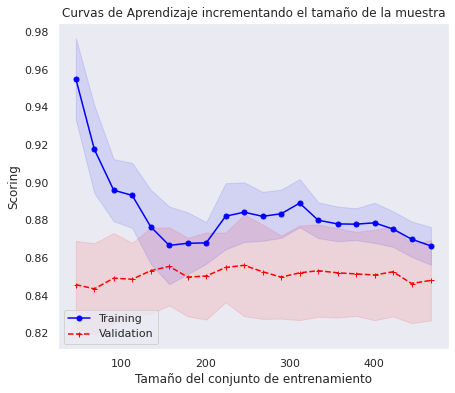

In [59]:
# MODELO DE SVC SIN MEJORES PARÁMETROS TRAIN

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas(Xtrain)

In [60]:
def mi_ModeloYCurvastest(Xin):

       modelo = svm.SVC()
       
       MODELS_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS_pipe ,    
                                                        X = Xin,
                                                        y = Ytest.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(accuracyFunction),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

CURVA CON DATOS DE VALIDACIÓN

Curvas de aprendizaje del modelo SVC:


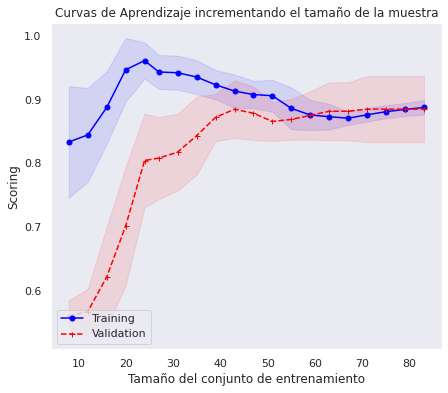

In [61]:
# MODELO DE SVC SIN MEJORES PARÁMETROS TEST

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvastest(Xtest)

OBTENEMOS GRÁFICAS CON LOS MEJORES HIPERPARÁMETROS POR MÉTRICA

ACCURACY (ENTRENAMIENTO)

In [66]:
def mi_ModeloYCurvas2(Xin):

       modelo2 = svm.SVC(C=10, gamma=0.01, kernel='rbf')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytrain.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(accuracyFunction),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


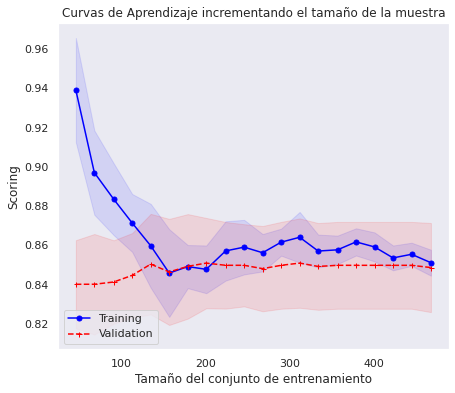

In [67]:
# MODELO DE SVC CON MEJORES PARÁMETROS TRAIN

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2(Xtrain)

ACCURACY (VALIDACIÓN)

In [68]:
def mi_ModeloYCurvas2test(Xin):

       modelo2 = svm.SVC(C=10, gamma=0.01, kernel='rbf')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytest.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(accuracyFunction),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


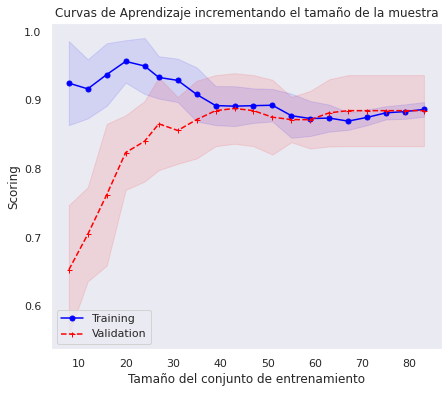

In [69]:
# MODELO DE SVC CON MEJORES PARÁMETROS TEST

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2test(Xtest)

F1 SCORE ENTRENAMIENTO

In [75]:
def mi_ModeloYCurvas2(Xin):

       modelo2 = svm.SVC(C=0.1, gamma=0.1, kernel='rbf')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytrain.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(f1Function),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


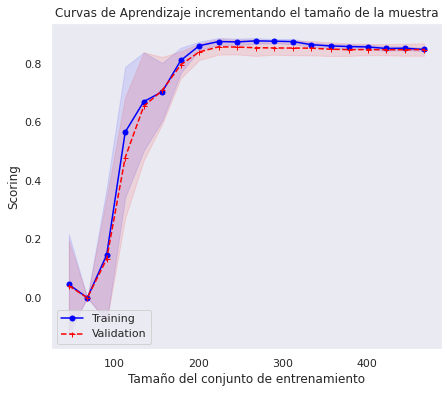

In [77]:
# MODELO DE SVC CON MEJORES PARÁMETROS TRAIN

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2(Xtrain)

F1 SCORE VALIDACIÓN

In [74]:
def mi_ModeloYCurvas2(Xin):

       modelo2 = svm.SVC(C=0.1, gamma=0.1, kernel='rbf')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytest.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(f1Function),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


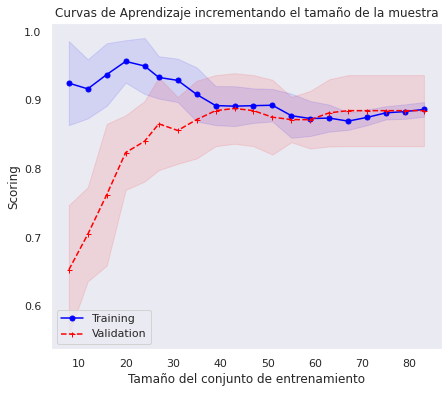

In [76]:
# MODELO DE SVC CON MEJORES PARÁMETROS TEST

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2test(Xtest)

RECALL ENTRENAMIENTO

In [73]:
def mi_ModeloYCurvas2(Xin):

       modelo2 = svm.SVC(C=1, gamma=0.1, kernel='sigmoid')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytrain.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(recallFunction),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


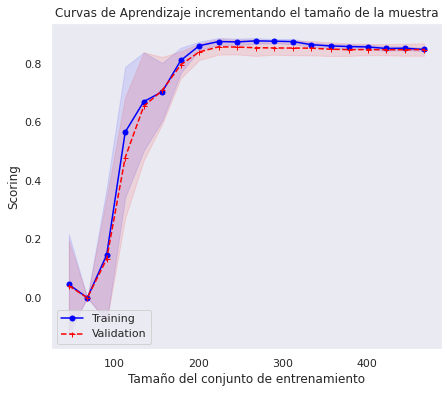

In [78]:
# MODELO DE SVC CON MEJORES PARÁMETROS TRAIN

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2(Xtrain)

RECALL VALIDACIÓN

In [72]:
def mi_ModeloYCurvas2(Xin):

       modelo2 = svm.SVC(C=1, gamma=0.1, kernel='sigmoid')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytest.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(recallFunction),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


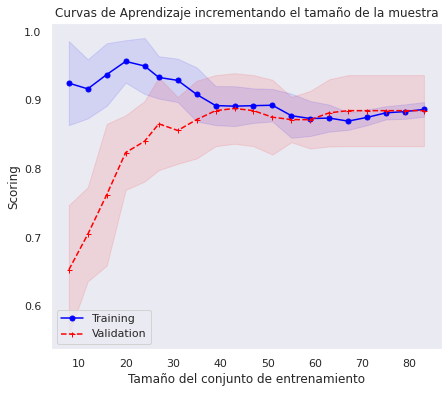

In [79]:
# MODELO DE SVC CON MEJORES PARÁMETROS TEST

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2test(Xtest)

PRECISION ENTRENAMIENTO

In [71]:
def mi_ModeloYCurvas2(Xin):

       modelo2 = svm.SVC(C=1, gamma=0.001, kernel='rbf')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytrain.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(precisionFunction),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


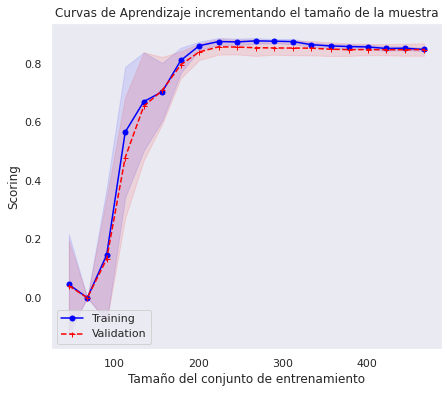

In [80]:
# MODELO DE SVC CON MEJORES PARÁMETROS TRAIN

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2(Xtrain)

PRECISION VALIDACIÓN

In [70]:
def mi_ModeloYCurvas2(Xin):

       modelo2 = svm.SVC(C=1, gamma=0.001, kernel='rbf')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytest.values.ravel(),
                                                        cv = kfold,
                                                        scoring = make_scorer(precisionFunction),
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


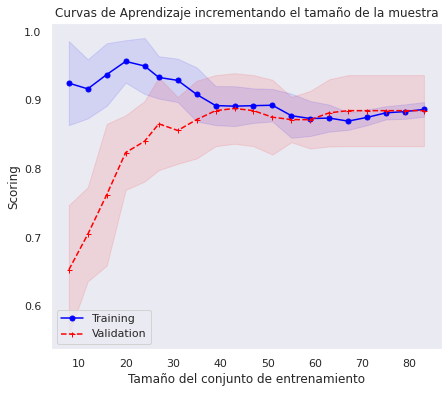

In [81]:
# MODELO DE SVC CON MEJORES PARÁMETROS TEST

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2test(Xtest)

#**Ejercicio-7.**

Con los mejores hiperparámetros entontrados encontrar la gráfica de la curva ROC y su área bajo la curva.

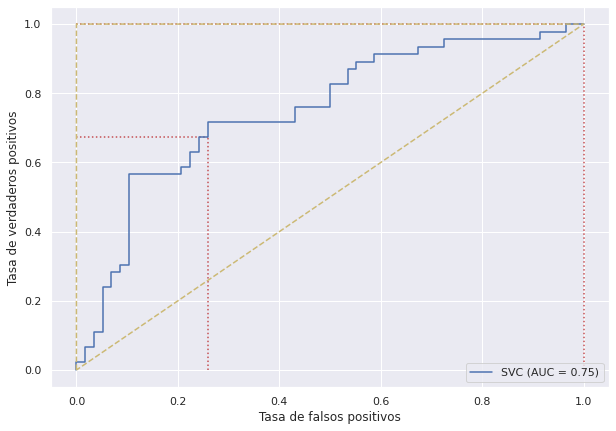

In [48]:
# TRAEMOS EL MODELO CON LOS MEJORES HIPERPARÁMETROS

SVM_final = svm.SVC(C=1, gamma=0.001, kernel='rbf')
SVM_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", SVM_final)])
SVM_score = cross_validate(SVM_pipe, Xtrain, Ytrain, scoring=make_scorer(precisionFunction), cv=SVM_kfold, return_train_score=True)

SVM_final.fit(Xtrain, Ytrain)

YtestSVM_hat = SVM_final.predict(Xtest)

#define métricas
fpr, tpr, _ = roc_curve(Ytest, YtestSVM_hat)

#create plt de la curva ROC

RocCurveDisplay.from_estimator(SVM_final, Xtest, Ytest)
plt.plot([0,0,1,0],[0,1,1,0], 'y--')
plt.hlines(tpr, 0, fpr, colors='r', linestyles='dotted')  
plt.vlines(fpr, 0, tpr, colors='r', linestyles='dotted') 

plt.ylabel(' Tasa de verdaderos positivos ')
plt.xlabel(' Tasa de falsos positivos ')
plt.show()

#**Ejercicio-8.**

Encontrar el valor del mejor umbral de predicción del modelo que maximice el valor de la métrica f1-score. 

Best Threshold (Mejor umbral)=1.000000, F1-Score=0.674


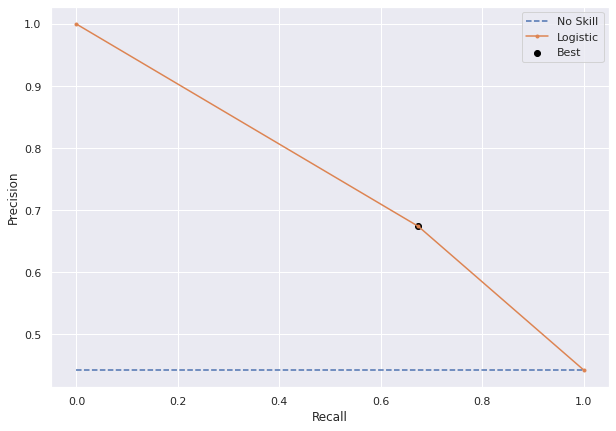

In [49]:
#Encontrar el valor del mejor umbral de predicción del modelo que maximice el valor de la métrica  f1-score. 
from sklearn.metrics import precision_recall_curve
YtestSVM_hat = SVM_final.predict(Xtest)
# Calculando curvas roc
precision, recall, thresholds = precision_recall_curve(Ytest, YtestSVM_hat)
# Convirtiendo a f1 score
fscore = (2 * precision * recall) / (precision + recall)
# Encontrando el index del mayor f1-score
ix = argmax(fscore)
print('Best Threshold (Mejor umbral)=%f, F1-Score=%.3f' % (thresholds[ix], fscore[ix]))
# Plot
no_skill = len(Ytest[Ytest==1]) / len(Ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# Etiquetas de la gráfica
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# Mostrando la gráfica
plt.show()




In [50]:
print('Podemos ver que la mejor medida F-1 fue 0.674 lograda con un umbral de alrededor de 1.0')

Podemos ver que la mejor medida F-1 fue 0.674 lograda con un umbral de alrededor de 1.0


#**Ejercicio-9.**

Encontrar el valor del mejor umbral de predicción del modelo que maximice el valor de la métrica g-mean. 

Best Threshold (Mejor umbral)= 0.6739130434782609
G-Mean=0.707


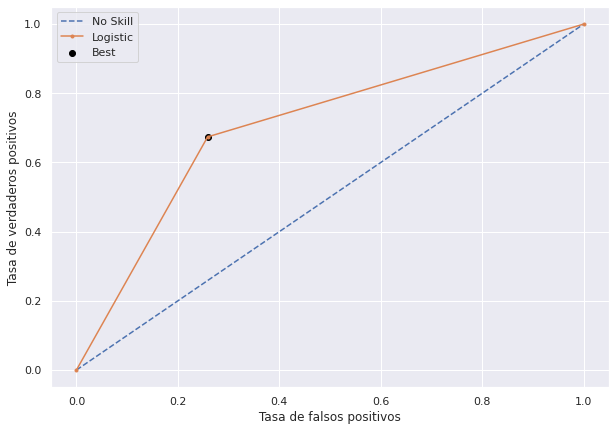

In [51]:
#Encontrar el valor del mejor umbral de predicción del modelo que maximice el valor de la métrica g-mean.  
thresholds = roc_curve(Ytest, YtestSVM_hat)
# Calculando G-mean
gmeans = sqrt(tpr * (1-fpr))
# Encontrando el index del mayor  g-mean
ix = argmax(gmeans)
print('Best Threshold (Mejor umbral)=',  (thresholds[ix][1]))
print('G-Mean=%.3f' % (gmeans[ix]))
# plot 
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# Etiquetas de la gráfica
plt.ylabel(' Tasa de verdaderos positivos ')
plt.xlabel(' Tasa de falsos positivos ')
plt.legend()
# Mostrando la gráfica
plt.show()

In [52]:
print('En este caso, podemos ver que el mejor valor de G-mean es de 0.707 con un umbral de aproximadamente 0.67391304')

En este caso, podemos ver que el mejor valor de G-mean es de 0.707 con un umbral de aproximadamente 0.67391304


#**Ejercicio-10.**

##Modelo SVM
###Un modelo SVM nos enseña los puntos de una muestra en el espacio y los separa en dos clases mediante un hiperplano de separación, este plano  o también conocido como vector soporte, está definido por 2 puntos de las clases más cercanas, con ayuda de este vector podemos saber a qué clase pertenece un nuevo dato dependiendo de si se clasifica en un lado o en el otro del hiperplano.

###¿Qué podemos observar?
###Resolver este ejercicio nos ayuda a visualizar las definiciones teóricas de una manera más tangible, por ejemplo, en este modelo en particular, podemos observar la curva ROC en el ejercicio 7 ,los valores pequeños en el eje X indican pocos falsos positivos y muchos verdaderos negativos, mientras que valores grandes en el eje Y indican elevados verdaderos positivos y pocos falsos negativos, con un rendimiento del modelo de 0.75, podemos decir entonces que se obtuvo un buen rendimiento de modelo, esto se puede corroborar porque la gráfica se encuentra desplazada hacia la izquierda.

###Por su parte en los ejercicios 8 y 9 podemos observar el valor del mejor umbral de predicción del modelo que maximiza el valor de de dos métricas, g-mean  y f1 score.

##¿Cuál es el umbral óptimo?
###Hay muchas maneras de ubicar el umbral con el equilibrio óptimo entre las tasas de falsos positivos y verdaderos positivos.La Media Geométrica o G-Mean es una métrica de clasificación desequilibrada que, si se optimiza, buscará un equilibrio entre la sensibilidad y la especificidad.Dado que ya hemos calculado la Sensibilidad (TPR) y el complemento de la Especificidad cuando calculamos la Curva ROC, podemos calcular el G-Mean para cada umbral directamente y posteriormente podemos ubicar el índice para la puntuación media G más alta y usar ese índice para determinar qué valor de umbral usar.Lo mismo sucede para el valor de F1-score.

##Referencias
Torres, L. (2022, 2 noviembre). ¿Qué funciona mejor para evaluar un modelo de clasificación en Python? The Machine Learners. https://www.themachinelearners.com/curva-roc-vs-prec-recall/




###**Fin de la Actividad de la semana 8.**